## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
import matplotlib.image as mpimg
from scipy.interpolate import interp1d
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Select one image and apply distortion correction

In [2]:
img = cv2.imread(images[0])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imshow('und',undist)
cv2.imwrite('../camera_cal/undistorted/undistorted1.jpg',undist)
cv2.waitKey(500)
cv2.destroyAllWindows()

## Take one of the sample images of the scene and apply distortion correction using the calibrated camera matrices

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


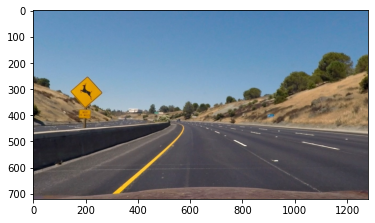

In [3]:
#reading in an image
image = cv2.imread('test_images/test2.jpg')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(image, mtx, dist, None, mtx)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
cv2.imwrite('camera_cal/undistorted/undistorted3.jpg',undistorted)
undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
plt.imshow(undistorted)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Defining thresholding functions and developing a thresholded binary image

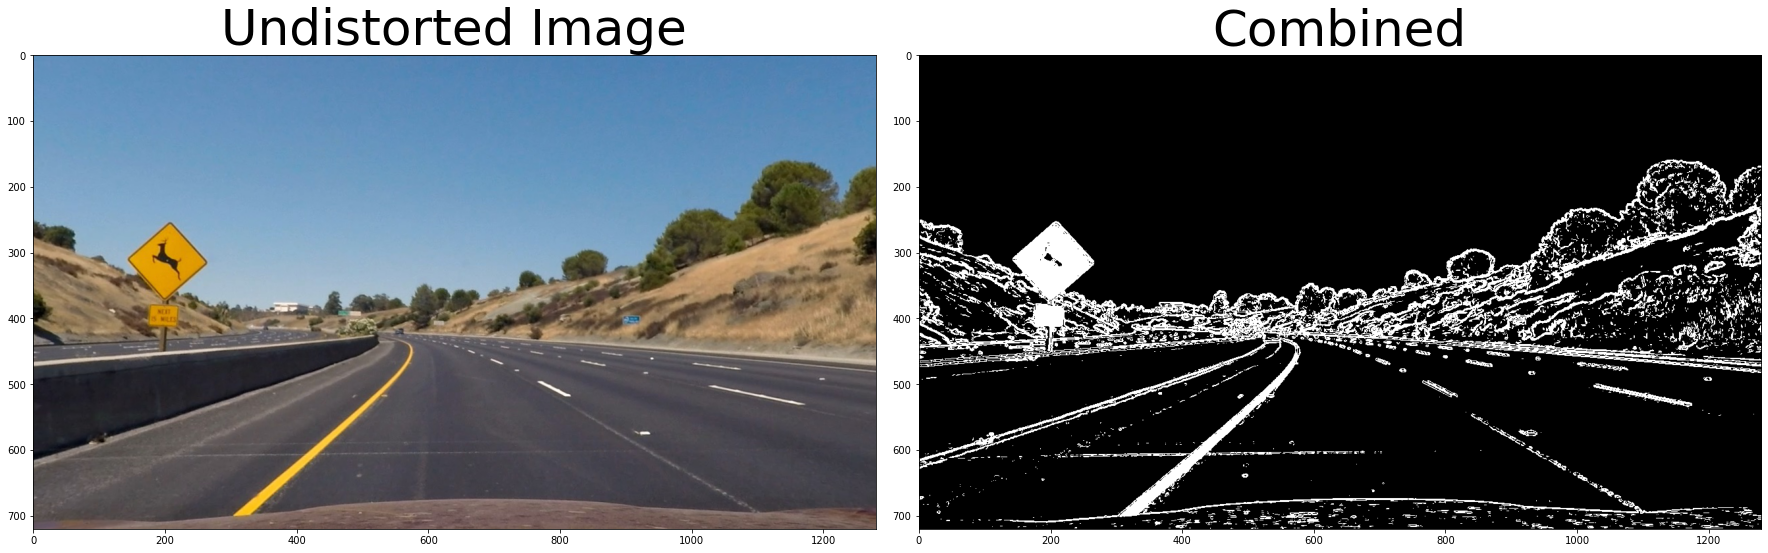

In [4]:
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return grad_binary

def mag_thresh(image, sobel_kernel, mag_thresh):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    # 6) Return this mask as your binary_output image
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel, thresh):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    graddir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(graddir)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    # 6) Return this mask as your binary_output image
    dir_binary[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return dir_binary

def channel_select(img,channel, thresh):
    if channel == 'r':
        channel = img[:,:,0]
    if channel == 'g':
        channel = hls[:,:,1]
    if channel == 'b':
        channel = hls[:,:,2]
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'h':
        channel = hls[:,:,0]
    if channel == 'l':
        channel = hls[:,:,1]
    if channel == 's':
        channel = hls[:,:,2]
    channel_output = np.zeros_like(channel)
    channel_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return channel_output

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
def thresholding(image, ksize):
    hls_binary = channel_select(image, channel = 's',thresh=(170, 255))
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(1.1, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) | (grady == 1) | (hls_binary==1) | (mag_binary == 1) & (dir_binary == 1)] = 1
    return combined

combined = thresholding(undistorted, 3)
cv2.imwrite('camera_cal/undistorted/lanes_binary.jpg',combined*255)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Carrying out perspective transform and plotting lines

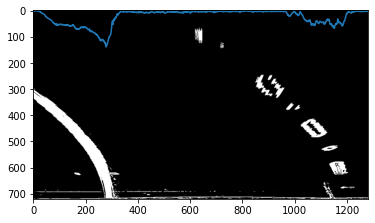

In [5]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]# select bottom half of the image
    histogram = np.sum(bottom_half, axis=0)# summ each index
    return histogram

vertices_warped = np.array([[[int(image.shape[1]*0), image.shape[0]],[int(image.shape[1]*0), int(image.shape[0]*0)],[int(image.shape[1]*1), int(image.shape[0]*0)],[int(image.shape[1]*1), image.shape[0]]]])
height = gray.shape[0]
width = gray.shape[1]
src = np.float32([[int(image.shape[1]*0), image.shape[0]],[int(image.shape[1]*0.47), int(image.shape[0]*0.61)],[int(image.shape[1]*0.53), int(image.shape[0]*0.61)],[int(image.shape[1]), image.shape[0]]])
dst = np.float32([[0,height],[0,0],[width,0],[width,height]])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undistorted, M, (width,height), flags=cv2.INTER_LINEAR) 
#thresholding the image
thresh_warped = thresholding(warped, 3)

histogram = hist(thresh_warped)
left_lane = histogram[:histogram.shape[0]//2]
left_lane_index = np.where(left_lane == max(left_lane))
right_lane = histogram[histogram.shape[0]//2:]
right_lane_index = histogram.shape[0]//2 + np.where(right_lane == max(right_lane))[0]
output_warped = cv2.merge([thresh_warped*255,thresh_warped*255,thresh_warped*255]).astype(np.uint8)
# Visualize the resulting histogram
plt.plot(histogram)
plt.imshow(output_warped)
plt.savefig('camera_cal/undistorted/perspective_lane.png')

## Implementing siding window, identifying lans-pixels and fitting a polynomial

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


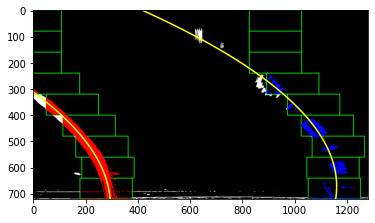

In [6]:
# Load our image
binary_warped = thresh_warped

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit


out_img, left_fit, right_fit = fit_polynomial(binary_warped)

plt.imshow(out_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


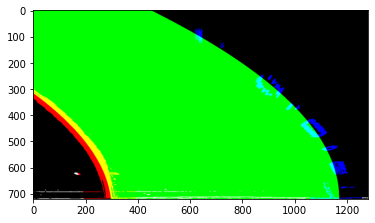

In [13]:
# Load our image - this should be a new frame since last time!
binary_warped = thresh_warped

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    binary_warped_shape = binary_warped.shape
    image_midpoint = binary_warped_shape[1]/2
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped_shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    right_line = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.flip(right_line,1)
    lane = np.hstack((left_line, right_line))
    cv2.fillPoly(window_img, np.int_([lane]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit[0]*y_eval*ym_per_pix)**2)**(1.5))/np.absolute(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit[0]*y_eval*ym_per_pix)**2)**(1.5))/np.absolute(2*right_fit[0])  ## Implement the calculation of the right line here
    
    left_lane_point = left_fitx[np.where(y_eval)]
    right_lane_point = right_fitx[np.where(y_eval)]
    lane_midpoint = (left_lane_point + right_lane_point)/2
    shift = (image_midpoint - lane_midpoint)*(3.7/700)
    curvature = np.round((left_curverad + right_curverad)/2)
    shift = np.round(shift[0]).astype(np.float64)
    
    return curvature, shift, result

#def draw_lane()

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
curvature, shift, result = search_around_poly(binary_warped, left_fit, right_fit)

# View your output
plt.imshow(result)

## Changing Warped image to original image transfrom

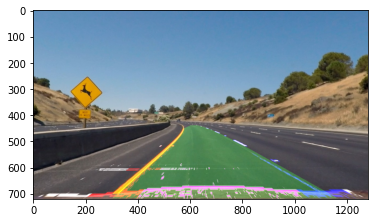

In [15]:
M1 = cv2.getPerspectiveTransform(dst, src)
warped_to_original = cv2.warpPerspective(result, M1, (width,height), flags=cv2.INTER_LINEAR).astype(np.uint8)
output = cv2.addWeighted(undistorted, 1, warped_to_original, 0.8, 0)
plt.imshow(output)

## Write text on the image

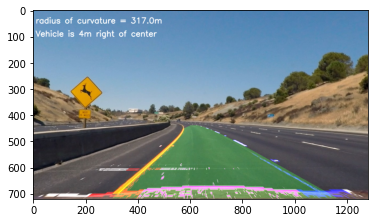

In [16]:
def status_vehicle(image,curvature, shift):
    font = cv2.FONT_HERSHEY_SIMPLEX# font
    org = (10, 50)# org
    fontScale = 1# fontScale
    color = (255, 255, 255)# Red color in RGB
    thickness = 2# Line thickness of 2 px
    curvature_text = 'radius of curvature = '+ str(curvature)+ 'm'
    output = cv2.putText(image, curvature_text, org, font, fontScale, color, thickness, cv2.LINE_AA)# Using cv2.putText() method
    try:
        if shift < 0:
            shift_text = 'Vehicle is '+ str(np.absolute(shift[0]))+ 'm left of center'
            output = cv2.putText(output, shift_text, (10,100), font, fontScale, color, thickness, cv2.LINE_AA)
        else:
            shift_text = 'Vehicle is '+ str(np.absolute(shift))+ 'm right of center'
            output = cv2.putText(output, shift_text, (10,100), font, fontScale, color, thickness, cv2.LINE_AA)
    except IndexError:
        shift_text = 'Vehicle is '+ '0'+ 'm right of center'
        output = cv2.putText(output, shift_text, (10,100), font, fontScale, color, thickness, cv2.LINE_AA)
    return output
output = status_vehicle(output, curvature, shift)
plt.imshow(output)
        

## Test on videos

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pygame 2.0.1 (SDL 2.0.14, Python 3.6.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [18]:
def pipeline(image):
    global mtx, dist, left_fit
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
    height = undistorted.shape[0]
    width = undistorted.shape[1]
    src = np.float32([[int(image.shape[1]*0), image.shape[0]],[int(image.shape[1]*0.47), int(image.shape[0]*0.61)],[int(image.shape[1]*0.53), int(image.shape[0]*0.61)],[int(image.shape[1]), image.shape[0]]])
    dst = np.float32([[0,height],[0,0],[width,0],[width,height]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistorted, M, (width,height), flags=cv2.INTER_LINEAR) 
    #thresholding the image
    thresh_warped = thresholding(warped, 3)
    try:
        curvature, shift, result = search_around_poly(thresh_warped, left_fit, right_fit)
    except UnboundLocalError:
        out_img, left_fit, right_fit = fit_polynomial(thresh_warped)
        curvature, shift, result = search_around_poly(thresh_warped, left_fit, right_fit)
    M1 = cv2.getPerspectiveTransform(dst, src)
    warped_to_original = cv2.warpPerspective(result, M1, (width,height), flags=cv2.INTER_LINEAR).astype(np.uint8)
    output = cv2.addWeighted(undistorted, 1, warped_to_original, 0.8, 0)
    output = status_vehicle(output, curvature, shift)
    return output

## Project Video

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_images/project_video_output.mp4.
Moviepy - Writing video output_images/project_video_output.mp4



Moviepy - Done !
Moviepy - video ready output_images/project_video_output.mp4
Wall time: 5min 5s


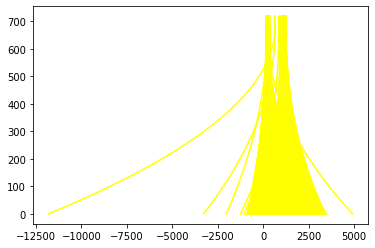

In [19]:
white_output = 'output_images/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Challenge Video

In [ ]:
white_output = 'output_images/Challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Harder Challenge Video

In [ ]:
white_output = 'output_images/harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))